# Example implementation of the ESU subgraph enumeration algorithm in python

Load the packages that we will need

In [141]:
import igraph
import random
import collections

Set the random number seed to ``1337``:

In [ ]:
random.seed(1337)

Define an ``exclusive_neighborhood`` function which takes three arguments:
- ``graph`` the whole graph object
- ``v`` a single vertex, as an integer
- ``Vp`` a ``set`` of vertices

returns: a ``set`` of vertex IDs of the set difference ``N(v)-N(Vp)``

side effects: none

In [131]:
def exclusive_neighborhood(graph, v, Vp):
    assert type(graph)==igraph.Graph
    assert type(v)==int
    assert type(Vp)==set
    Nv = set(graph.neighborhood(v))
    NVpll = graph.neighborhood(list(Vp))
    NVp = set([u for sublist in NVpll for u in sublist])
    return Nv - NVp

Define the ``extend_subgraph`` function, which takes six arguments:
- ``graph`` the whole graph object
- ``Vsubgraph`` which is a ``set`` of vertices (cardinality 1--k)
- ``Vextension`` which is a ``set`` of vertices (cardinality 0--N)
- ``v`` which is the start vertex from which we are to extend
- ``k`` the integer number of vertices in the motif (only sane values are 3 or 4)
- ``k_subgraphs`` a list of subgraph objects (modified)

Returns: nothing (but see ``k_subgraphs`` which is really the return data)

side effects:  ``Vextension`` and ``k_subgraphs`` are modified

In [132]:
def extend_subgraph(graph, Vsubgraph, Vextension, v, k, k_subgraphs):
    assert type(graph)==igraph.Graph
    assert type(Vsubgraph)==set
    assert type(Vextension)==set
    assert type(v)==int
    assert type(k)==int
    assert type(k_subgraphs)==list
    if len(Vsubgraph) == k:
        k_subgraphs.append(Vsubgraph)
        assert 1==len(set(graph.subgraph(Vsubgraph).clusters(mode=igraph.WEAK).membership))
        return
    while len(Vextension) > 0:
        w = random.choice(tuple(Vextension))
        Vextension.remove(w)
        ## obtain the "exclusive neighborhood" Nexcl(w, vsubgraph)
        NexclwVsubgraph = exclusive_neighborhood(graph, w, Vsubgraph)
        VpExtension = Vextension | set([u for u in NexclwVsubgraph if u > v])
        extend_subgraph(graph, Vsubgraph | set([w]), VpExtension, v, k, k_subgraphs)
    return

Define the ``enumerate_subgraphs`` function, which takes two arguments:
- ``graph``, the whole graph object
- ``k``, the integer number of vertices in the motif (only sane values are 3 or 4)

returns: a list of ``set`` objects containing the vertices of each of the size ``k`` subgraphs

side effects: none

In [133]:
def enumerate_subgraphs(graph, k):
    assert type(graph)==igraph.Graph
    assert type(k)==int
    k_subgraphs = []
    for vertex_obj in graph.vs:
        v = vertex_obj.index
        Vextension = set([u for u in G.neighbors(v) if u > v])
        extend_subgraph(graph, set([v]), Vextension, v, k, k_subgraphs)
    return k_subgraphs

Make an undirected Barabasi-Albert graph G with 20 vertices and 3 edges per step (using ``igraph.Graph.Barabasi``); as usual, print the graph summary

In [129]:
N = 6
K = 2
G = igraph.Graph.Barabasi(N, K)
G.summary()

'IGRAPH U--- 6 9 -- '

Let's take a look at the structure of this graph that we made, using ``igraph.drawing.plot``:

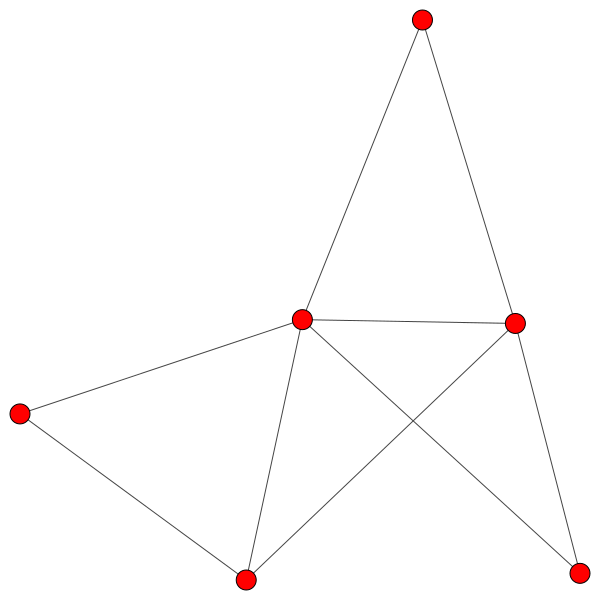

In [130]:
igraph.drawing.plot(G)

Now let's run our ``ESU`` algorithm code with ``k=4``, and get back the list of subgraphs:

In [134]:
sgset = enumerate_subgraphs(G,4)

Let's print the list of subgraphs:  (What type is each list element?)

In [137]:
sgset

[{0, 2, 4, 5},
 {0, 1, 4, 5},
 {0, 3, 4, 5},
 {0, 2, 3, 4},
 {0, 1, 3, 4},
 {0, 1, 2, 4},
 {0, 1, 2, 5},
 {0, 1, 3, 5},
 {0, 2, 3, 5},
 {0, 1, 2, 3},
 {1, 2, 3, 4},
 {1, 3, 4, 5},
 {1, 2, 3, 5}]

We don't know the isomorphism class of each of these subgraphs.  Let's use ``igraph.Graph.isoclass`` for that:

In [140]:
subgraph_isoclass_list = [G.subgraph(list(sg)).isoclass() for sg in sgset]
subgraph_isoclass_list

[4, 7, 7, 4, 9, 9, 7, 9, 7, 9, 4, 6, 6]

Now let's count the isomorphism classes that we got, using ``collections.Counter``:

In [135]:
collections.Counter([G.subgraph(list(sg)).isoclass() for sg in sgset])

Counter({4: 3, 6: 2, 7: 4, 9: 4})

If our code is correct, it should give the same results as running ``igraph.Graph.motifs_randesu`` with ``k=4``:

In [136]:
G.motifs_randesu(4)

[nan, nan, nan, nan, 3, nan, 2, 4, 0, 4, 0]

Take a close look; are they consistent?